In [1]:
import pandas as pd
import datetime as dt
from pandas.core.frame import DataFrame
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup
import watermark
from collections import namedtuple

from pathlib import Path
print(
    watermark.watermark(iversions=True, python=True,
                        machine=True, globals_=globals())
)

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.21.0

Compiler    : GCC 14.2.0
OS          : Linux
Release     : 6.10.6-gentoo
Machine     : x86_64
Processor   : AMD Ryzen 9 5950X 16-Core Processor
CPU cores   : 32
Architecture: 64bit

numpy     : 1.26.4
pandas    : 2.2.2
seaborn   : 0.13.2
requests  : 2.31.0
watermark : 2.4.3
matplotlib: 3.9.2



In [2]:
lang_dict = {
    "C": "C/C++",
    "C++": "C/C++",
    "Delphi/Object Pascal": "Delphi/Pascal",
    "MATLAB": "Matlab",
    "Cobol": "COBOL",
    # "VBA": "Visual Basic",
    "Powershell": "PowerShell",
    "VBScript": 'VBA/VBS',
    "VBA": "VBA/VBS",
    "ABAP": "Abap",
}

In [3]:
tiobe_url = "https://www.tiobe.com/tiobe-index/"


def get_tiobe_rank(url: str) -> DataFrame:
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        # Найти таблицу с индексом TIOBE по ее структуре или каким-то уникальным признакам
        # Это пример и может потребоваться адаптация
        table_class = "table table-striped table-top20"
        table = soup.find("table", {"class": table_class})
        rows = table.find_all("tr")

        ratings = []
        for row in rows[1:]:  # Пропустить заголовок таблицы
            # print(row)
            cols = row.find_all("td")
            # Извлечь необходимые данные из столбцов
            if len(cols) > 3:
                rank = int(cols[0].text.strip())
                lang = cols[4].text.strip()
                share = float(cols[5].text.replace("%", "").strip())
                trend = float(cols[6].text.replace("%", "").strip())
                ratings.append(
                    {"rank": rank, "lang": lang, "share": share, "trend": trend}
                )

        table = soup.find("table", {"id": "otherPL"})
        rows = table.find_all("tr")

        for row in rows[1:]:  # Пропустить заголовок таблицы
            # print(row)
            cols = row.find_all("td")
            # Извлечь необходимые данные из столбцов
            if len(cols) > 2:
                rank = int(cols[0].text.strip())
                lang = cols[1].text.strip()
                share = float(cols[2].text.replace("%", "").strip())
                trend = None
                ratings.append(
                    {"rank": rank, "lang": lang, "share": share, "trend": trend}
                )

    else:
        print("Не удалось получить данные с сайта TIOBE.")

    tiobe_rank = pd.DataFrame(ratings)
    tiobe_rank = tiobe_rank.replace(
        lang_dict).groupby("lang").sum().reset_index()
    return tiobe_rank


tiobe_rank = get_tiobe_rank(tiobe_url)
tiobe_rank

,lang,rank,share,trend
0,(Visual) FoxPro,26,0.82,0.00
1,Abap,39,0.30,0.00
2,Ada,30,0.61,0.00
3,Assembly language,17,1.21,-0.13
4,Awk,46,0.19,0.00
5,Bash,49,0.17,0.00
6,C#,5,6.39,-0.65
7,C/C++,5,19.21,-2.83
8,COBOL,21,1.09,0.00
9,Classic Visual Basic,22,1.04,0.00


In [4]:
def get_pypl_rank(url: str) -> DataFrame:
    # URL индекса популярности PYPL

    # Отправляем HTTP запрос и получаем результат
    response = requests.get(url)
    response.raise_for_status()  # Вызовет исключение, если запрос не успешен

    start_word = "<!-- begin section All-->"
    end_word = "<!-- end section All-->"
    start_idx = response.text.find(start_word) + len(start_word)
    end_idx = response.text.find(end_word)
    # Парсим HTML с помощью BeautifulSoup
    soup = BeautifulSoup(
        f"<tr>{response.content[start_idx:end_idx]}", "html.parser")
    rows = soup.find_all("tr")
    # Извлекаем данные о языках программирования и их доле
    ratings = []
    for row in rows:
        columns = row.find_all("td")
        rank = columns[0].text.strip()
        lang = columns[2].text.strip()
        share = float(columns[3].text.replace("%", "").strip())
        trend = float(columns[4].text.replace("%", "").strip())
        ratings.append({"rank": rank, "lang": lang,
                       "share": share, "trend": trend})
    df = pd.DataFrame(ratings)
    df.replace(lang_dict, inplace=True)
    return df


pypl_url = "https://pypl.github.io/PYPL.html"
# Получаем и выводим рейтинг языков программирования
pypl_rank = get_pypl_rank(pypl_url)
pypl_rank

,rank,lang,share,trend
0,1,Python,29.60,1.7
1,2,Java,15.51,-0.3
2,3,JavaScript,8.38,-1.0
3,4,C#,6.70,-0.0
4,5,C/C++,6.31,-0.2
5,6,R,4.60,0.2
6,7,PHP,4.35,-0.6
7,8,TypeScript,2.93,-0.1
8,9,Swift,2.76,0.1
9,10,Rust,2.58,0.5


In [5]:
rank_all = pd.merge(
    tiobe_rank, pypl_rank, on="lang", how="outer", suffixes=("_tiobe", "_pypl")
)
rank_all['trend_norm'] = np.sqrt(rank_all.fillna(
    0)['trend_tiobe']**2+rank_all.fillna(0)['trend_pypl']**2)
rank_all

,lang,rank_tiobe,share_tiobe,trend_tiobe,rank_pypl,share_pypl,trend_pypl,trend_norm
0,(Visual) FoxPro,26.0,0.82,0.00,NaN,NaN,NaN,0.000000
1,Abap,39.0,0.30,0.00,22,0.57,-0.0,0.000000
2,Ada,30.0,0.61,0.00,19,0.96,-0.1,0.100000
3,Assembly language,17.0,1.21,-0.13,NaN,NaN,NaN,0.130000
4,Awk,46.0,0.19,0.00,NaN,NaN,NaN,0.000000
5,Bash,49.0,0.17,0.00,NaN,NaN,NaN,0.000000
6,C#,5.0,6.39,-0.65,4,6.70,-0.0,0.650000
7,C/C++,5.0,19.21,-2.83,5,6.31,-0.2,2.837058
8,COBOL,21.0,1.09,0.00,26,0.19,-0.1,0.100000
9,Classic Visual Basic,22.0,1.04,0.00,NaN,NaN,NaN,0.000000


In [6]:
short_rank_all = rank_all.dropna(subset=["rank_tiobe", "rank_pypl"], how="any")
short_rank_all

,lang,rank_tiobe,share_tiobe,trend_tiobe,rank_pypl,share_pypl,trend_pypl,trend_norm
1,Abap,39.0,0.30,0.00,22,0.57,-0.0,0.000000
2,Ada,30.0,0.61,0.00,19,0.96,-0.1,0.100000
6,C#,5.0,6.39,-0.65,4,6.70,-0.0,0.650000
7,C/C++,5.0,19.21,-2.83,5,6.31,-0.2,2.837058
8,COBOL,21.0,1.09,0.00,26,0.19,-0.1,0.100000
11,Dart,29.0,0.63,0.00,17,0.99,0.0,0.000000
12,Delphi/Pascal,12.0,1.63,0.83,29,0.06,-0.1,0.836002
16,Go,9.0,2.03,0.87,12,2.14,0.2,0.892693
18,Haskell,28.0,0.69,0.00,28,0.10,-0.1,0.100000
19,Java,4.0,9.16,-1.16,2,15.51,-0.3,1.198165


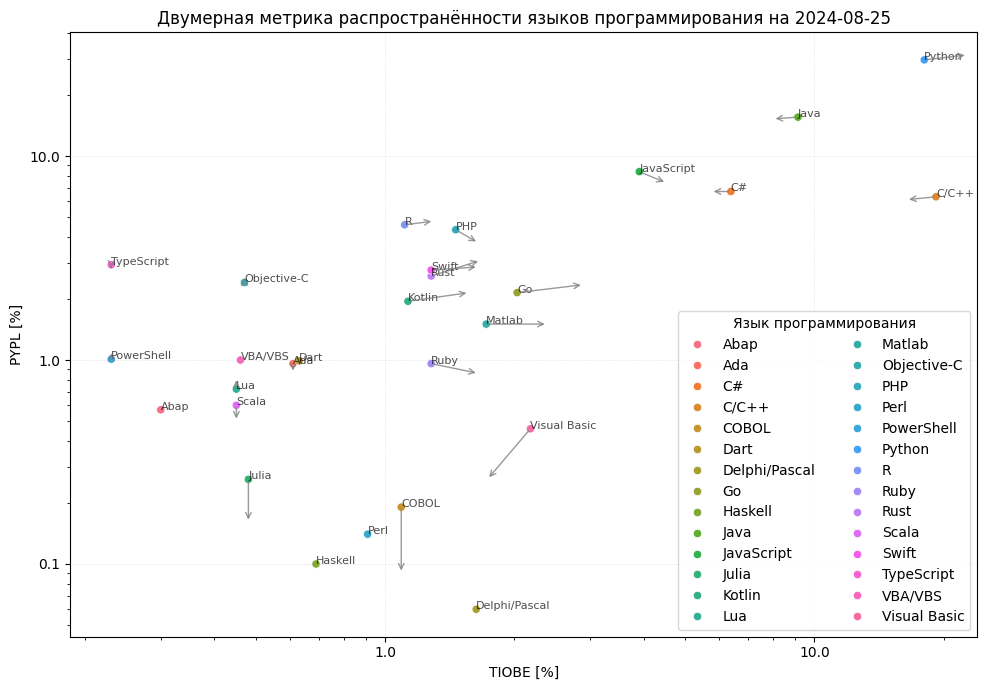

In [7]:
def norm(a, b) -> float:
    return (a**2 + b**2)**(1/2)


fig = plt.figure(figsize=(10, 7))
ax = sns.scatterplot(data=short_rank_all, x="share_tiobe",
                     y="share_pypl", hue="lang")
plt.xscale("log")
plt.yscale("log")
ax.set(
    xlabel="TIOBE [%]",
    ylabel="PYPL [%]",
    title=f"Двумерная метрика распространённости языков программирования на {
        dt.date.today()}",
    # xlim=(0, 50),
    # ylim=(0, 50),
)
ax.grid(ls=":", lw=0.5, alpha=0.5)
for x in short_rank_all.dropna().itertuples():
    ax.text(x.share_tiobe, x.share_pypl, x.lang, fontsize=8, alpha=0.7)
    if (x.trend_tiobe is not None) and (x.trend_pypl is not None) and x.trend_norm > 0.0:
        ax.annotate(
            "",
            xy=(x.trend_tiobe + x.share_tiobe, x.trend_pypl + x.share_pypl),
            xytext=(x.share_tiobe, x.share_pypl),
            arrowprops=dict(arrowstyle="->", lw=1, alpha=0.8, color="grey"),
        )
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(loc="lower right", ncol=2, title="Язык программирования")
fig.tight_layout()
fig.savefig(Path("output.png"), dpi=300)

## Расчёт с учётом оценки производительности

In [8]:
alias_bench = {
    'chapel': 'Chapel',
    'clang': 'C/C++',
    'csharpaot': 'C#',
    'csharpcore': 'C#',
    'dartexe': 'Dart',
    'dartjit': 'Dart',
    'erlang': 'Erland',
    'fpascal': 'Free Pascal',
    'fsharpcore': 'F#',
    'gcc': 'C/C++',
    'ghc': 'Haskell',
    'gnat': 'Ada',
    'go': 'Go',
    'gpp': 'C/C++',
    'graalvm': 'Graal',
    'icx': 'C/C++',
    'ifc': 'Fortran',
    'ifx': 'Fortran',
    'java': 'Java',
    'javaxint': 'Java',
    'julia': 'Julia',
    'lua': 'Lua',
    'micropython': 'Python',
    'mri': 'Ruby',
    'node': 'JavaScript',
    'ocaml': 'OCaml',
    'openj9': 'Java',
    'perl': 'Perl',
    'pharo': 'Smalltalk',
    'php': 'PHP',
    'python3': 'Python',
    'racket': 'Racket',
    'ruby': 'Ruby',
    'rust': 'Rust',
    'sbcl': 'Lisp',
    'swift': 'Swift',
    'toit': 'Toit',
    'vw': ''
}

In [9]:
bench_game = pd.read_csv(Path("data/alldata.csv"))
bench_game = bench_game[bench_game['status'] >= 0]
bench_game.drop(columns=['id', 'n'], inplace=True)
bench_game

,name,lang,size(B),cpu(s),mem(KB),status,load,elapsed(s),busy(s),started(s)
0,binarytrees,sbcl,595,0.021,19568,0,0% 0% 0% 28%,0.070,0.020,0.0
1,binarytrees,sbcl,595,0.091,90368,0,100% 10% 0% 0%,0.092,0.101,0.0
2,binarytrees,sbcl,595,9.645,550616,0,100% 0% 0% 0%,9.647,9.743,0.0
3,binarytrees,sbcl,595,9.593,550616,0,100% 0% 0% 0%,9.595,9.623,0.0
4,binarytrees,sbcl,595,9.643,550488,0,39% 60% 0% 0%,9.648,9.744,0.0
...,...,...,...,...,...,...,...,...,...,...
9672,toosimple,javaxint,206,3.312,36456,0,0% 1% 98% 0%,3.333,3.373,0.0
9673,toosimple,javaxint,206,323.603,36596,0,100% 0% 0% 0%,323.488,324.458,0.0
9674,toosimple,python3,150,0.181,19660,0,0% 23% 0% 1%,0.774,0.194,0.0
9675,toosimple,python3,150,11.219,19660,0,0% 0% 67% 32%,11.221,11.310,0.0


In [10]:
a = bench_game.groupby(['lang', 'name']).min(
    numeric_only=True).groupby('lang').median()
a['lang_name'] = a.index.map(alias_bench)
a

,size(B),cpu(s),mem(KB),status,elapsed(s),busy(s),started(s),lang_name
lang,,,,,,,,
chapel,526.0,0.0575,19680.0,0.0,0.2745,0.0555,0.0,Chapel
clang,654.0,0.0300,19700.0,0.0,0.0300,0.0270,0.0,C/C++
csharpaot,641.0,0.0770,19696.0,0.0,0.2060,0.0850,0.0,C#
csharpcore,641.0,0.1760,31092.0,0.0,0.3890,0.1810,0.0,C#
dartexe,511.5,0.0790,19662.0,0.0,0.0815,0.0810,0.0,Dart
dartjit,511.5,1.3190,152594.0,0.0,1.0445,1.3300,0.0,Dart
erlang,871.0,1.2460,55598.0,0.0,1.5695,1.2980,0.0,Erland
fpascal,959.0,0.0660,19672.0,0.0,0.0740,0.0700,0.0,Free Pascal
fsharpcore,725.5,0.2395,33156.0,0.0,0.3580,0.2385,0.0,F#


In [11]:
a = a.groupby('lang_name').median().sort_values(
    by="elapsed(s)", ascending=True)
a

,size(B),cpu(s),mem(KB),status,elapsed(s),busy(s),started(s)
lang_name,,,,,,,
C/C++,654.0,0.02800,19692.0,0.0,0.02950,0.03050,0.0
Rust,883.5,0.02250,19072.0,0.0,0.04400,0.01750,0.0
Go,658.5,0.06100,19808.0,0.0,0.04500,0.06000,0.0
Fortran,780.0,0.04800,19650.0,0.0,0.06050,0.04750,0.0
OCaml,473.0,0.06000,19672.0,0.0,0.06050,0.07600,0.0
Free Pascal,959.0,0.06600,19672.0,0.0,0.07400,0.07000,0.0
Lisp,905.5,0.10850,19680.0,0.0,0.16300,0.10850,0.0
Haskell,801.5,0.06850,19808.0,0.0,0.21600,0.07400,0.0
Ada,1259.0,0.07150,19760.0,0.0,0.24650,0.08000,0.0


In [12]:
a.sort_values(by="cpu(s)", ascending=True)

,size(B),cpu(s),mem(KB),status,elapsed(s),busy(s),started(s)
lang_name,,,,,,,
Rust,883.5,0.02250,19072.0,0.0,0.04400,0.01750,0.0
C/C++,654.0,0.02800,19692.0,0.0,0.02950,0.03050,0.0
Fortran,780.0,0.04800,19650.0,0.0,0.06050,0.04750,0.0
Chapel,526.0,0.05750,19680.0,0.0,0.27450,0.05550,0.0
OCaml,473.0,0.06000,19672.0,0.0,0.06050,0.07600,0.0
Go,658.5,0.06100,19808.0,0.0,0.04500,0.06000,0.0
Free Pascal,959.0,0.06600,19672.0,0.0,0.07400,0.07000,0.0
Haskell,801.5,0.06850,19808.0,0.0,0.21600,0.07400,0.0
Ada,1259.0,0.07150,19760.0,0.0,0.24650,0.08000,0.0


In [13]:
b = short_rank_all.join(a['elapsed(s)'], on="lang")
b['slower'] = b['elapsed(s)']/(b['elapsed(s)'].min())
for col in ['share_tiobe', 'share_pypl', 'trend_tiobe', 'trend_pypl']:
    b[col] = b[col]/b['slower']
b.dropna(inplace=True)
b

,lang,rank_tiobe,share_tiobe,trend_tiobe,rank_pypl,share_pypl,trend_pypl,trend_norm,elapsed(s),slower
2,Ada,30.0,0.073002,0.000000,19,0.114888,-0.011968,0.100000,0.24650,8.355932
6,C#,5.0,0.633630,-0.064454,4,0.664370,-0.000000,0.650000,0.29750,10.084746
7,C/C++,5.0,19.210000,-2.830000,5,6.310000,-0.200000,2.837058,0.02950,1.000000
11,Dart,29.0,0.033011,0.000000,17,0.051874,0.000000,0.000000,0.56300,19.084746
16,Go,9.0,1.330778,0.570333,12,1.402889,0.131111,0.892693,0.04500,1.525424
18,Haskell,28.0,0.094236,0.000000,28,0.013657,-0.013657,0.100000,0.21600,7.322034
19,Java,4.0,0.313844,-0.039744,2,0.531411,-0.010279,1.198165,0.86100,29.186441
20,JavaScript,6.0,0.233966,0.037099,3,0.501440,-0.059838,1.176605,0.49300,16.711864
21,Julia,32.0,0.022441,0.000000,25,0.012155,-0.004675,0.100000,0.63100,21.389831
25,Lua,35.0,0.015250,0.000000,20,0.024400,0.003389,0.100000,0.87050,29.508475


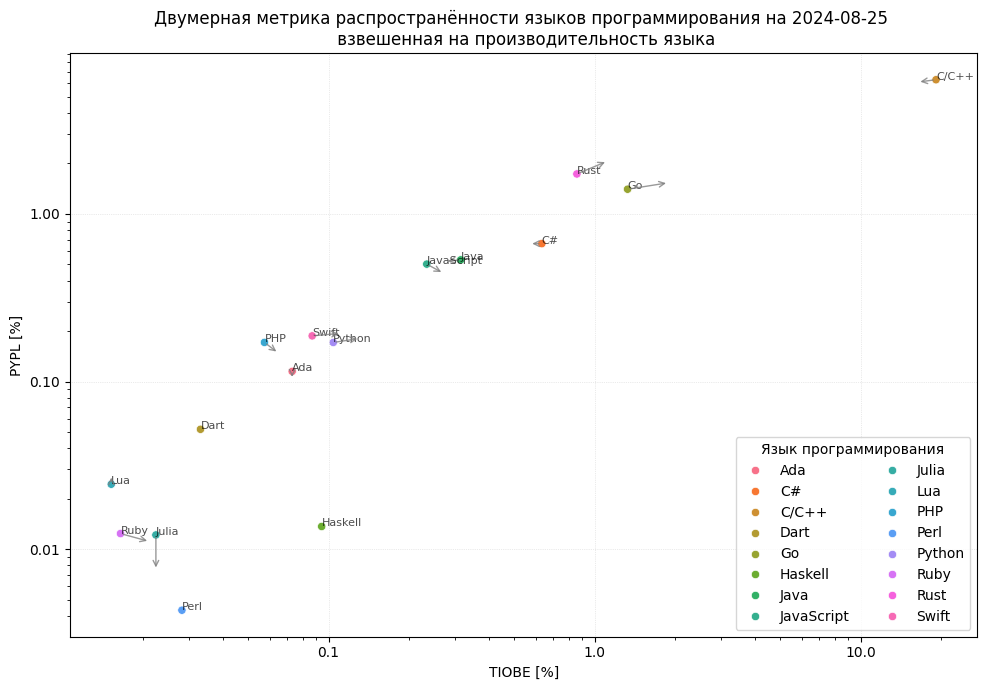

In [14]:
fig = plt.figure(figsize=(10, 7))
ax = sns.scatterplot(data=b.dropna(), x="share_tiobe",
                     y="share_pypl", hue="lang")
plt.xscale("log")
plt.yscale("log")
ax.set(
    xlabel="TIOBE [%]",
    ylabel="PYPL [%]",
    title=f"Двумерная метрика распространённости языков программирования на {
        dt.date.today()} \n взвешенная на производительность языка",
    # xlim=(0, 50),
    # ylim=(0, 50),
)
ax.grid(ls=":", lw=0.5, alpha=0.5)
for x in b.dropna().itertuples():
    ax.text(x.share_tiobe, x.share_pypl, x.lang, fontsize=8, alpha=0.7)
    if (x.trend_tiobe is not None) and (x.trend_pypl is not None) and x.trend_norm > 0.0:
        ax.annotate(
            "",
            xy=(x.trend_tiobe + x.share_tiobe, x.trend_pypl + x.share_pypl),
            xytext=(x.share_tiobe, x.share_pypl),
            arrowprops=dict(arrowstyle="->", lw=1, alpha=0.8, color="grey"),
        )
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(loc="lower right", ncol=2, title="Язык программирования")
fig.tight_layout()
fig.savefig(Path("perf_rank.png"), dpi=300)